## Imports

In [ ]:
import numpy as np
import scipy as sp
import matplotlib as mpl
mpl.rc('figure', max_open_warning =1000)
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import pandas as pd
pd.set_option("display.max_rows", 1000)
from bs4 import BeautifulSoup 
import requests
import re
import os
import logging
from datetime import datetime as dt
import itertools as itr

## Acquire Data

The following code snippet (you can expand the cell if you're curious) shows how the data was collected from John's Hopkin's University Center for Computer Studies Github repository.  It should be noted that it doesn't run on Kaggle (perhaps as a bandwidth limiter), but does on a home computer

In [ ]:
def getFileList(homepage):
    """Use BeautifulSoup to fetch a file list from the GitHub page stored in homepage"""
    source = requests.get(homepage).text
    soup = BeautifulSoup(source, 'lxml')
    files = []
    for markup in soup.find_all('a', class_='js-navigation-open'):
        arr = markup.get_text().split('\n')
        if re.search('\d\d\-\d\d\-\d\d\d\d.csv',arr[0]):
            files.append(arr[0])
    return files

def exDate(sDat, sFormat='%m-%d-%Y'):
    """remove the extension from a file name formated in sFormat and return a datetime object"""
    return dt.strptime(sDat[0:-4], sFormat)

def strfdat(datIn, sFormat = '%m-%d-%Y'): 
    """return a filename with a .csv extension and a date formatted string name"""
    return datIn.strftime(sFormat)+'.csv'

def trimFileList(fetchList, datCutOff, sFormat = '%m-%d-%Y'):
    """Pop any files of the form %m-%d-%Y.csv out of fetchList if they occur on or before any of the files in dirList"""
    fetchFile = fetchList
    retList = []
    for n in range(len(fetchFile)):
        if dt.strptime(fetchFile[n].split('.')[0], sFormat) > datCutOff: 
            retList.append(fetchFile[n])
    return retList

def removeUndated(fileList, sFormat = '%m-%d-%Y'):
    undatedRemoved = fileList
    n = 0
    while n <= len(undatedRemoved):
        try:
            n += 1
            dt.strptime(undatedRemoved[n-1].split('.')[0], sFormat)
        except ValueError:
            pop = undatedRemoved.pop(n-1)
            n -= 1
        except IndexError:
            break
    return undatedRemoved

def sortFileList(fileList):
    fl = np.array(list(map(exDate, fileList)))
    fl = np.sort(fl)
    #Convert sorted arrray back to an array of file names
    fl = list(map(strfdat, fl))
    return fl

def grabDataFromURL(urlroot, filename):
    url = urlroot+'/'+filename
    logger.info('grabDataFromURL() - Grabbing and adding data from file at ' + url)
    #Check the date and grab the data according the the correct schema
    if dt.strptime(filename.split('.')[0], '%m-%d-%Y') < dt.strptime("03-01-2020", '%m-%d-%Y'):
        df2 = pd.read_csv(filepath_or_buffer = url, sep = ',', index_col= False, header = 0,\
                         names = ['province', 'country', 'recorded', 'confirmed', 'deaths', 'recovered'])
    elif dt.strptime(filename.split('.')[0], '%m-%d-%Y') < dt.strptime("03-22-2020", '%m-%d-%Y'):
        df2 = pd.read_csv(filepath_or_buffer = url, sep = ',', index_col= False, header = 0,\
                names = ['province', 'country', 'recorded', 'confirmed', 'deaths', 'recovered', 'lat', 'lon'])
    elif dt.strptime(filename.split('.')[0], '%m-%d-%Y') < dt.strptime("05-29-2020", '%m-%d-%Y'):
        df2 = pd.read_csv(filepath_or_buffer = url, sep = ',', index_col= False, header = 0,\
                names = ['fips', 'city', 'province', 'country', 'recorded', 'lat', 'lon', 'confirmed', 'deaths', 'recovered', 'active', 'combined_key'])        
    else:
        df2 = pd.read_csv(filepath_or_buffer = url, sep = ',', index_col= False, header = 0,\
                names = ['fips', 'city', 'province', 'country', 'recorded', 'lat', 'lon', 'confirmed', 'deaths', 'recovered', 'active', 'combined_key', 'incidence_rate', 'case-fatality_ratio'])
    #log what's been grabbed
    logger.info('grabDataFromURL() - Data grabbed is \n' + str(df2.values) + '\n')
    return df2                    

#define variables
homepage = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports'
urlroot = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports'    
localpath = 'C:\\Users\\Sean\\Documents\\Dev\\Covid-19\\'
    
#Create logger
LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
logging.basicConfig(filename = localpath+'Covid-19.log',
                   level = logging.DEBUG,
                   format = LOG_FORMAT,
                   filemode = 'w')
logger = logging.getLogger()

# Execution
try: 
    fl = getFileList(homepage)
    # Convert fl to to numpy series of dates to prepare for descending sort
    ldir = os.listdir(localpath)
    # Remove the files from ldir that don't conform to a date
    ldir = removeUndated(ldir)    
    ldir = sortFileList(ldir)
    # Remove files from fl that have already been grabbed and sit in local files
    if len(ldir) > 0:
        fl = trimFileList(fl, exDate(ldir[-1]))
    # Sort the remaining files in the file list
    fl = sortFileList(fl)         
    # Prepare empty dataframe for population
    df = pd.DataFrame()
    if len(ldir) > 0:
        df = pd.read_csv(localpath+ldir[-1])        
    for n in fl:
        df2 = grabDataFromURL(urlroot, n)
        df2.insert(0, 'file', n.split('.')[0])
        df = df.append(df2)
    # Drop columns like "Unnamed:*" that are getting created in the Dataframe.append() process
    rexp = re.compile('^Unnamed:')
    for n in list(df.columns):
        if rexp.match(n):
            df.drop(n, axis =1, inplace = True)    
    # save the accumulated file locally
    if len(fl) > 0:
        if fl[-1] not in os.listdir(localpath):
            df.to_csv(localpath+'\\'+fl[-1])        
    logger.info('pull_data() - output \n'+str(df.values))
    
finally:
    logging.shutdown()

## Cleaning Data

The following code snippet (you can expand the cell if you're curious) illustrates how the data that was collected was cleaned.


In [ ]:
def add_column(sName, df, fFunc):def add_column(sName, df, fFunc):
    df2 = df.copy()
    newCol = []
    for n in range(0, df.shape[0]):
        newCol.append(fFunc(df2, n))
    df2[sName] = newCol
    return df2    
    
def get_mDate(df, n):
    datestr = df['file'][n]
    datestrrec = df['recorded'][n]
    dtime = dt.strptime(datestrrec, getDateFormatString(datestr, datestrrec))
    return mdates.date2num(dtime)

# def get_mDate(df,n):
#     dTime = dt.strptime(df['file'][n], '%m-%d-%Y')
#     return np.floor(mdates.date2num(dTime))

def get_Active(dftemp, n):
#     import pdb; pdb.set_trace()
    confirmed = dftemp['confirmed'][n]
    recovered = dftemp['recovered'][n]
    deaths = dftemp['deaths'][n]
    rtypes = ['float', 'int', 'numpy.float64']
#     if type(confirmed) not in rtypes or type(recovered) not in rtypes or type(deaths) not in rtypes:
#         print('Wrong data type(s) detected.')
#         print('[confirmed] is %s of type %s.' %(confirmed, type(confirmed)))
#         print('[recovered] is %s of type %s.' %(recovered, type(recovered)))
#         print('[deaths] is %s of type %s.' %(deaths, type(deaths)))
#         print('[n] is %d, and [file] is %s' %(n, df['file'][n]))
#         return 0.0
#     else:
    return (confirmed - recovered - deaths)

def get_Resolved(df, n):
    return (df['recovered'][n]+df['deaths'][n])

def splDateStr(sDtime):
    sRecParts = re.split('[,-/:T .]', sDtime)
    for n in range(len(sRecParts)):
        sRecParts[n] = int(sRecParts[n])
    return sRecParts
    
def datInt(sDateRef):
    ldat = splDateStr(sDateRef)
    return ldat[1]+ldat[0]*31+ldat[2]*366
            
def compareDates(sDateRef, sDate):
    """Takes two date strings, the reference datestring [sDateRef] formatted as mm-dd-YYYY as a later date 
    that is reasonably close to the inspected datestring [sDate], and returns the most probable order for sDate"""
    lRef = splDateStr(sDate)
    a = str(lRef[0])
    b = str(lRef[1])
    c = str(lRef[2])
    nDate1 = datInt(sDate)
    nDate2 = datInt(str(b)+'-'+str(a)+'-'+str(c))
    nDate3 = datInt(str(b)+'-'+str(c)+'-'+str(a))
    refDat = splDateStr(sDateRef)
    sDateRef2 = str(refDat[0])+'-'+str(refDat[1])+'-'+str(refDat[2]%100)
    nDateRef = datInt(sDateRef)
    nDateRef2 = datInt(sDateRef2)
    lDiffs = np.array([nDateRef-nDate1, nDateRef-nDate2, nDateRef-nDate3,
                       nDateRef2 - nDate1, nDateRef2-nDate2, nDateRef2-nDate3])
    mask = lDiffs > -3
    bestMatch = lDiffs[mask].min()
    if abs(lDiffs[0])==abs(bestMatch):
        return 'mdY'
    elif abs(lDiffs[1])==abs(bestMatch):
        return 'dmY'
    elif abs(lDiffs[2])==abs(bestMatch):
        return 'Ymd'
    elif abs(lDiffs[3])==abs(bestMatch):
        return 'mdy'
    elif abs(lDiffs[4])==abs(bestMatch):
        return 'dmy'
    elif abs(lDiffs[5])==abs(bestMatch):
        return 'ymd'
    else:
        return None

def getDateFormatString(sDateRef, sDate):
    lookup = memoDictDt2Fmt.get(sDate, 'None')
    if  lookup == 'None':
        sep = re.split('\d+', sDate)
        sSeq = compareDates(sDateRef, sDate)
        sFormat = '%'+sSeq[0]+sep[1]+'%'+sSeq[1]+sep[2]+'%'+sSeq[2]+sep[3]
        nParts = len(re.split('[,-/:T .]', sDate))
        if nParts == 5:
            sFormat = sFormat+"%H"+sep[4]+'%M'
        elif nParts == 6:
            sFormat = sFormat+"%H"+sep[4]+'%M'+sep[5]+'%S'
        elif nParts == 7:
            sFormat = sFormat+"%H"+sep[4]+'%M'+sep[5]+'%S'+sep[6]+'%f'
        memoDictDt2Fmt[sDate]=sFormat
        return sFormat
    else:
        return lookup

df2 = df.copy()

df2.reset_index(inplace=True, drop = True)
df2['deaths'] = df2['deaths'].fillna(0.0)
df2['confirmed']= df2['confirmed'].fillna(0.0)
df2['recovered']= df2['recovered'].fillna(0.0)
df2 = add_column('calc_active', df2, get_Active)
df2 = add_column('resolved', df2, get_Resolved)
memoDictDt2Fmt = {}
df2 = add_column('mDate', df2, get_mDate)
# df2['flmDate'] = np.floor(df2['mDate'])
# df2.drop_duplicates(subset = ['flmDate', 'country', 'province'], inplace = True)

# Strip string values
df2['country']=list(map(lambda n: n.strip(), df2['country']))
df2['province']=df2['province'].fillna('')
df2['city']=df2['city'].fillna('')
# df2['province']=list(map(lambda n: n.strip(), df2['province']))
# df2['admin2']=list(map(lambda n: n.strip(), df2['admin2']))
#Clarifications needed as some countries are referred to by more than one identifier
replaceDict = {'Mainland China':'China', 'Bahamas, The':'Bahamas',
               'The Bahamas': 'Bahamas', 'Taipei and environs':'Taiwan',
              'Gambia, The': 'Gambia', 'The Gambia':'Gambia', 'Republic of Ireland':'Ireland',
              'UK':'United Kingdom', 'Congo (Brazzaville)':'Republic of the Congo',
              'Congo (Kinshasa)':'Democratic Republic of the Congo'}
df2.replace(replaceDict, inplace=True)

# df2['country'].replace(to_replace='Hong Kong', value = 'China', inplace=True)
# logger.info('transform_data() - returning df\n'+str(df.values))

dropList = {'province': ['Unassigned Location, WA', 'Unknown Location, MA', 'Recovered', 'None', 'Unknown',
                        'Diamond Princess', 'Grand Princess', 'Grand Princess Cruise Ship', 'From Diamond Princess',
                        'Lackland, TX (From Diamond Princess)', 'Omaha, NE (From Diamond Princess)',
                        'Travis, CA (From Diamond Princess)', 'Unassigned Location (From Diamond Princess)'],
           'country': ['Others', 'Russian Federation', 'Viet Nam', 'Cruise Ship', 'MS Zaandam', 'Diamond Princess']}
for rgn in dropList:
    for item in dropList[rgn]:
        df2.drop(df2[df2[rgn] == item].index, axis = 0, inplace = True)

#change [province, country] pairs
corrDict = {('Chicago','US'):['Chicago, IL','US'], ('Macau', 'Macau'):['Macau', 'China'],
            ('','Taiwan*'):['','Taiwan'], ('Macau', 'Macao SAR'):['Macau SAR', 'China'],
            ('', 'Macao SAR'):['Macau SAR','China'], ('Denmark','Denmark'):['Mainland','Denmark'],
            ('France','France'):['Mainland', 'France'], ('','Mayotte'):['Mayotte', 'France'],
            ('','Reunion'):['Reunion', 'France'], ('','Saint Martin'):['Saint Martin', 'France'],            
            ('', """"('St. Martin',)"""):['Saint Martin', 'France'],
            ('','Saint Barthelemy'):['Saint Barthelemy', 'France'],
            ('Mexico','Mexico'):['','Mexico'],
            ('Netherlands', 'Netherlands'):['Mainland','Netherlands'], 
            ('Taiwan','Taiwan'):['','Taiwan'],
            ('United Kingdom','United Kindgom'):['England','United Kingdom'], 
            ('', 'North Ireland'):['Northern Irelend','United Kingdom'], 
            ('', 'Hong Kong'):['Hong Kong SAR', 'China'], 
            ('Hong Kong', 'China'):['Hong Kong SAR', 'China'],
            ('Hong Kong', 'Hong Kong'):['Hong Kong SAR', 'China'],
            ('Hong Kong','Hong Kong SAR'):['Hong Kong SAR', 'China'],
            ('','Hong Kong SAR'):['Hong Kong SAR', 'China'], 
            ('','Iran (Islamic Republic of)'):['','Iran'],
            ('','French Guiana'):['French Guiana','France'], 
            ('','Channel Islands'):['Channel Islands', 'United Kingdom'],
            ('','Cayman Islands'):['Cayman Islands', 'United Kingdom'],
            ('','Korea, South'):['', 'Republic of Korea'],
            ('','South Korea'):['','Republic of Korea'], 
            ('','Republic of Moldova'):['','Moldova'],
            ('','occupied Palestinian territory'):['','Palestine'],
            ('','West Bank and Gaza'):['','Palestine']   }
for rgn in corrDict:
    sProv, sCtry = rgn
    sNewProv, sNewCtry = corrDict[rgn]
    flt = (df2['province'] == sProv) & (df2['country'] == sCtry)
    df2.loc[flt,'province'] = df2.loc[flt,'province'].replace(to_replace = sProv, value = sNewProv)
    df2.loc[flt,'country'] = df2.loc[flt,'country'].replace(to_replace = sCtry, value = sNewCtry)

# drop 4 rows for US, US only because they don't fit into part of a larger sequence
flt = (df2['country'] == 'US') & (df2['province'] == 'US')
df2.drop(df2[flt].index, axis = 0, inplace = True)
df2.to_csv(localpath+'\\Cleaned_Data.csv')

## Plotting Data

In [ ]:
def getMortRate(df):
    deaths = df['deaths'].to_numpy()[-1]
    cases = df['confirmed'].to_numpy()[-1]
    lastdate = df.index.to_numpy()[-1] - DaysToResolve
    df2 = df[df.index <= lastdate]
    if df2.shape[0]>0:
        cases = df2['confirmed'].to_numpy()[-1]
    if deaths > cases:
        deaths = cases
    if cases != 0:
        return np.abs(100*deaths/cases)
    else:
        return np.NaN

def PlotCases(df, sTitle):
    fontsz = (12,15)
    fig, ax = plt.subplots(1, 1, figsize=(16,9))
    ax.plot(df['mDate'], df['confirmed'],label='All Cases', color='b')
    ax.plot(df['mDate'], df['active'], label = 'Active Cases', color = 'orange')
    ax.plot(df['mDate'], df['resolved'], label = 'Resolved Cases', color='g')
    ax.set_ylim(0, max(ax.get_ylim())*1.1)
    ax2 = ax.twinx()
    ax2.fill_between(df['mDate'], 0, df['deaths'], label = 'Deaths', color='r', alpha = 0.2)
    if (df['deaths'].max() == np.NaN) or (df['deaths'].max() == 0):
        deaths = 5.0
    else:
        deaths = df['deaths'].max()  
    ax2.set_ylim(0, 2*deaths)
    ax2.grid(False)
    xMortRate = getMortRate(df)
    if xMortRate != np.nan and xMortRate > 0.0:
        xPos = (df['mDate'].to_numpy()[-1]+df['mDate'].to_numpy()[0])/2
        yPos = (max(plt.ylim())/10)
        plt.text(xPos, yPos, 'Mortality Rate: '+"{:.2f}".format(xMortRate)+'%',\
                verticalalignment = 'bottom', horizontalalignment = 'center',\
                color = 'k', fontsize=fontsz[0], alpha=0.6)
    leg = ax.legend(loc=2,ncol=1,prop={'size':fontsz[0]})
    leg.get_frame().set_alpha(0.4)
    leg = ax2.legend(loc=6,ncol=1,prop={'size':fontsz[0]})
    leg.get_frame().set_alpha(0.4)
    ax.grid()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('1 %b %y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=6))
    plt.title(sTitle, size=fontsz[1])
    fig.autofmt_xdate()
    plt.show()

def getPlotData(df, country, province = '', city = '', ):
    if len(city) > 0:
        flt = (df['country']==country) & (df['province']==province) & (df['city']==city)
        dfint = df[flt].loc[:,['mDate', 'confirmed', 'calc_active', 'deaths', 'resolved']]
        dfint['mDate']=np.floor(dfint.loc[:, 'mDate'])
        dfint.drop_duplicates(subset = 'mDate', inplace = True)
        return dfint.groupby('mDate').agg(\
                    confirmed = ('confirmed', ['first']),\
                    active = ('calc_active', 'first'),\
                    deaths = ('deaths', 'first'),\
                    resolved = ('resolved', 'sum'))
    elif (len(province) >0):
        flt = ((df['country']==country) & (df['province']==province))
        dfint = df[flt].loc[:,['city', 'mDate', 'confirmed', 'calc_active', 'deaths', 'resolved']]
        dfint['mDate'] = np.floor(dfint.loc[:, 'mDate'])
        dfint.drop_duplicates(subset = ['mDate', 'city'], inplace = True)
        return dfint.groupby('mDate').agg(\
                    confirmed = ('confirmed', 'sum'),\
                    active = ('calc_active', 'sum'),\
                    deaths = ('deaths', 'sum'),\
                    resolved = ('resolved', 'sum'))
    else:
        flt = (df['country']==country)
        dfint = df[flt].loc[:,['province', 'city', 'mDate', 'confirmed', 'calc_active', 'deaths', 'resolved']]
        dfint['mDate'] = np.floor(dfint.loc[:, 'mDate'])
        dfint.drop_duplicates(subset = ['mDate', 'province', 'city'], inplace = True)
        return dfint.groupby('mDate').agg(\
                    confirmed = ('confirmed', 'sum'),\
                    active = ('calc_active', 'sum'),\
                    deaths = ('deaths', 'sum'),\
                    resolved = ('resolved', 'sum'))

DaysToResolve = 18
url = '../input/pull-datacsv/Cleaned_Data.csv'

df3 = pd.read_csv(url)

for country in df3.groupby('country'):
    sCountry = country[0].strip()
    df4 = getPlotData(df3, country = sCountry)
    df4 = df4.reset_index()
    if df4.shape[0]>30:
        PlotCases(df4, sTitle= sCountry)
    for province in df3[df3['country']==country[0]].groupby('province'):
        sProvince = province[0].strip()
        if sProvince != '':
            df4 = getPlotData(df3, country= sCountry, province = sProvince)
            df4 = df4.reset_index()
            if df4.shape[0]>30:
                PlotCases(df4, sTitle = sProvince+', '+sCountry)

## Analysing Regional Data

First, create a data frame that can be used to store information gathered for each region.

In [ ]:
def populateRegions(dfIn):
    dfReturn = dfIn.loc[:,['province', 'country']]
#    Some countries in the list are only represented by their provinces, so it is necessary to append a list of countries
    dfAppend = dfIn.loc[:, ['country']]
    dfAppend['province'] = np.NaN
    dfReturn = dfReturn.append(dfAppend)
#     dfReturn['country']=list(map(lambda name: name.strip(), dfReturn['country']))
#     dfReturn['province']=list(map(lambda name: name.strip(), dfReturn['province']))
    dfReturn = dfReturn.drop_duplicates().sort_values(by= ['country', 'province'], ascending=True)
    dfReturn.reset_index(inplace = True, drop = True)
    return dfReturn

dfRegionData = populateRegions(df3)
dfRegionData

Next, I want to evaluate how long, on average, it takes for patients in each region to achieve 'resolved' status from the time they are recorded as having been infected.  in this case $n_{resolved} = n_{deaths} + n_{recovered}$ and is representative of the R in the S.I.R. model for epidemic progression.  To make this calculation, we know that 100% of cases will resolve, and so we simply compute the average difference between the date $n_{cases}$ reached a certain level and the date at which $n_{resolved}$ reached that same level.

In [ ]:
def getDays2Resolve(df, country, province = ''):
    dfSeries = getPlotData(df, country, province)
    dfSeries.reset_index(inplace = True)
    #cycle down from the end of the series locating the date of the 
    #   lowest number of confirmed that is greater than resolved
    resolvedays = []
    for n in dfSeries.index[-1::-1]:
        res = dfSeries['resolved'][n]
        flt = dfSeries['confirmed']>=res
        if dfSeries[flt]['mDate'].shape[0]>0:
            dtconfirmed = dfSeries[flt]['mDate'].min()
            resolvedays.append(dfSeries['mDate'][n]-dtconfirmed)
    nresolve = np.array(resolvedays)
    if len(nresolve)>0:
        return nresolve.mean(), nresolve.std(), len(nresolve)
    else:
        return np.NaN, np.NaN, np.NaN

# print(getDays2Resolve(df3, 'Canada', 'Alberta'))
daysToRecover = []
for n in dfRegionData.index:
    prov = str(dfRegionData['province'][n])
    if prov != 'nan' and len(prov)>0:
        daysToRecover.append(getDays2Resolve(df3, dfRegionData['country'][n], dfRegionData['province'][n]))
    else:
        daysToRecover.append(getDays2Resolve(df3, country = dfRegionData['country'][n]))
nparr = np.array(daysToRecover)
dfRegionData['resolveDaysMean'] = nparr[:,0]
dfRegionData['resolveDaysStd'] = nparr[:,1]
dfRegionData['resolveDaysCount'] = nparr[:,2]
dfRegionData

Perform a scatter plot that shows the time to resolve on the x-axis and the standard deviation as a percentage of the time to resolve on the y-axis.  By looking for a cluster near the bottom of the plot, we will have identified the most probable value for the time to resolve if this could indeed be considered a property of the Covid-19 disease.  To help weed out poorer-quality data, I choose to restrict the scatter plot to regions where the count of data points is higher than 30.

In [ ]:
dfPlotData = dfRegionData
flt = (dfPlotData['resolveDaysMean']>0.0) & (dfPlotData['resolveDaysStd']>0.0) & (dfPlotData['resolveDaysCount']>=30)
dfPlotData = dfPlotData[flt]
dfPlotData['ratio']=list(map(lambda x,y:x/y*100, dfPlotData['resolveDaysStd'],dfPlotData['resolveDaysMean']))
flt = dfPlotData['ratio']<140.0
dfPlotData = dfPlotData[flt]
fig = plt.figure(dpi=150, figsize = (8,8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.scatter(dfPlotData.loc[:,('resolveDaysMean')],dfPlotData.loc[:,('ratio')], s = 1)
ax2 = ax_histx.hist(dfPlotData['resolveDaysMean'], bins = 100, rwidth = 0.8)
ax3 = ax_histy.hist(dfPlotData['ratio'], bins = 100, rwidth =0.8, orientation = 'horizontal')
ax.grid(True)
ax_histx.grid(True)
ax_histy.grid(True)
ax.set_ylabel('Std. Dev. as a Percentage')
ax.set_xlabel('Days to Resolve')
ax_histx.set_title('Days to Resolve Covid-19 by Region')
font_dict = {'family':'serif',\
                'color':'darkred',\
                'size':8}
ax.text(40,80,'One region somewhere on earth represented by one marker.', fontdict = font_dict, ha = 'center', wrap = True)
fig.show()


This graph indicates a cluster of points that is elongated about a diagonal.  I interpret this as regions that report longer recovery times have greater variation in recovery times.  Even without the graph, it stands to reason that this would be true.  Several regions don't conform to this cluster, and it would seem these are the regions where there are problems with the data (in collection, reporting, or conveyance) such as with the arm that extends upward close to the [days to resolve] = 0 axis, or that these are regions that struggle with dealing with Covid-19 most acutely.  Either way, it's clear that 7 is not the correct number, but a number closer to 20 is acceptable.  This would increase the results for the calculations of mortality rates.

### Fitting curves

I first wish to fit an exponential curve to the leading edge of an epidemic in each reagion.  This will take on the form $$cases_{confirmed} = e^{k(t-t_0)}$$  A fit of this curve will provide $t_0$ as the start date of the pandemic for each region and $e^k$, the initial daily growth rate.  Note: the medical community defines the start date as the date at which 100 cases are confirmed.  However, this function defines a t_0 at the time where the first case would have been confirmed if the series conformed perfectly to an exponential progression.

To accomplish this, I can use linear regression to find the best fit to the series of confirmed cases $\{{c_0, c_1, c_2,...,c_n\}}$ after it is transformed using a logarithm $b_i = ln(c_i)$ to create another series $\{b_0, b_1, b_2,...,b_n\}$ that will conform to the linear progression $k\left(t-t_0\right)$.  After the best fit is found, it is a simple matter to reverse the transform to compare with the original series.

I wish to find the longest sustained segment of $\{c_n\}$ that can be said to fit exponential growth.  I observe the best fit will occur near the segment of the series $\{c_n\}$ where the daily growth rate, calculated as $r_d = \frac{c_{n+1}}{c_n\times(d_{n+1}-d_n)}$ is highest, and so I can eliminate much of the computation by choosing to eliminate the range of dates where the daily growth rate is in its 30th percentile or less.

Also, recall the formulae for linear regression:
- slope: $$k = \frac {n \left(\sum c_it_i \right) - \sum t_i \sum c_i}{n \left( \sum t_i^2 \right) - \left( \sum t_i \right)^2}$$
- y-interecept: $$kt_0 = \frac{ \left( \sum c_i \right) \left( \sum t_i^2 \right) - \sum t_i \sum c_it_i}{n \left( \sum t_i^2 \right) - \left( \sum t_i \right)^2}$$
- correlation coefficient $$r = \frac{\sum \left( t_i - \bar{t} \right) \left( c_i - \bar{c} \right)}{\sqrt{\sum \left( t_i - \bar{t} \right)^2 \sum \left( c_i - \bar{c} \right)^2 }}$$

In [ ]:
def linreg(df):
    """Returns linear regression data on first two columns of the indexed pandas Dataframe passed to it"""  
#     print(df)
    n = df.shape[0]
    sumxy, sumx, sumx2, sumy, sumy2, sumvarx, sumvary, sumvarxvary, sumvarx2, sumvary2 = 10 * [0.0, ]
    meanx, meany = df.mean()[0], df.mean()[1]
    for i in range(n):
        x = df.iloc[i,0]
        y = df.iloc[i,1]
#         print(x)
        sumxy += x * y
        sumx += x
        sumx2 += x ** 2
        sumy += y
        sumy2 += y ** 2
        sumvarx += x-meanx
        sumvary += y-meany
        sumvarxvary += sumvarx*sumvary
        sumvarx2 += np.square(sumvarx)
        sumvary2 += np.square(sumvary)
    m = (n*sumxy-sumx*sumy)/(n*sumx2 - sumx**2)
    b = (sumy*sumx2-sumx*sumxy)/(n*sumx2 - sumx**2)
    r = (sumvarxvary)/(sumvarx2 * sumvary2) ** 0.5
    return m, b, r

def get_Series(df, country, province = ''):
    dfint = getPlotData(df, country, province)
    # First, enumerate the date, value pairs by creating a dataframe with an index 
    dfint.reset_index(inplace = True)
    return dfint.loc[:, ['mDate', 'confirmed']]

def get_BestFitExp(df, country, province = ''):
    dfint = get_Series(df, country, province)
    #append daily growth rates
    growth = [0,]
    for n in range(dfint.shape[0]-1):
        timedif = dfint.iloc[n+1,0]-dfint.iloc[n,0]
        if timedif > 0:
            growth.append(dfint.iloc[n+1,1]/(dfint.iloc[n,1]*timedif))
        else:
            growth.append(np.NaN)
    dfint['dgrowth'] = growth
#     print(dfint)
    #determine range of greatest interest to reduce calculation time
    dfsorted = dfint.sort_values(by='dgrowth', ascending = False)
    dfsorted.reset_index(inplace=True)
#     print(dfsorted)
    cutoff = 0.1
    growthcutoff = dfsorted.loc[np.floor(dfsorted.shape[0]*cutoff), 'dgrowth']
#     print('Growth cut-off value is %s' % growthcutoff)
    flt = dfint['dgrowth'] >= growthcutoff
    dfsorted = dfint[flt]
#     print(dfsorted)
    highDate = dfsorted.agg({'mDate': 'max'})[0]
    lowDate = dfsorted.agg({'mDate': 'min'})[0]    
    #insert logarithm of 'confirmed'
    def lbind(value, cutoff):
        if value < cutoff:
            return cutoff
        else:
            return value
    dfint.insert(1, 'lnconfirmed', list(map(lambda value: np.log(lbind(value, np.exp(-100))), dfint['confirmed'])))
    #iterate through the series trimming leading and trailing dates, accepting each trim if r increases as a result
    #Grab the index of lowDate and highDate
    lowIndex = dfint.loc[dfint['mDate'] == lowDate].index[0]
    highIndex = dfint[(dfint['mDate'] == highDate)].index[0]
#     print('Starting lowIndex = %s and starting highIndex = %s' % (lowIndex, highIndex))
    #Define the minimum distance between lowIndex and highIndex
    minDist = 7
    maxIter = 100
    stopChecking = False
    bestR = linreg(dfint.loc[lowIndex:(highIndex+1), ['mDate', 'lnconfirmed']])  
    while (highIndex - lowIndex > minDist) & (not stopChecking) & (maxIter > 0):
        maxIter -= 1
        bestR = linreg(dfint.loc[lowIndex:(highIndex+1), ['mDate', 'lnconfirmed']])        
        if highIndex - lowIndex > minDist:
            rLowInside = linreg(dfint.loc[(lowIndex+1):(highIndex+1), ['mDate', 'lnconfirmed']])
            rHighInside = linreg(dfint.loc[(lowIndex):(highIndex), ['mDate', 'lnconfirmed']])
        else:
            rLowInside = (0, 0, 0)
            rHighInside = (0, 0, 0)
        if highIndex < (dfint.shape[0]-1):
            rHighOutside = linreg(dfint.loc[(lowIndex):(highIndex+2), ['mDate', 'lnconfirmed']])
        else:
            rHighOutside = (0,0,0)
        if lowIndex > 0:
            rLowOutside = linreg(dfint.loc[(lowIndex-1):(highIndex+1), ['mDate', 'lnconfirmed']])
        else:
            rLowOutside = (0,0,0)
        bestmove = np.max([(bestR[0]*bestR[2]), (rLowInside[0]*rLowInside[2]), \
                            (rHighInside[0]*rHighInside[2]), (rHighOutside[0]*rHighOutside[2]),\
                           (rLowOutside[0]*rLowOutside[2])])
        if bestmove == (bestR[0]*bestR[2]): #Stay put, most optimal solution has been achieved
            stopChecking = True
        elif bestmove == (rLowInside[0]*rLowInside[2]): #Increase lowIndex
            lowIndex += 1
#             print('Increasing lowIndex to %s' % lowIndex)
        elif bestmove == (rHighInside[0]*rHighInside[2]): #Decrease highIndex
            highIndex -= 1
#             print('Decreasing highIndex to %s' % highIndex)
        elif bestmove == (rHighOutside[0]*rHighOutside[2]): #Increase highIndex
            highIndex += 1
#             print('Increasing highIndex to %s' % highIndex)
        elif bestmove == (rLowOutside[0]*rLowOutside[2]): #Decrease lowIndex
            lowIndex -= 1
#             print('Decreasing lowIndex to %s' % lowIndex)
    bestR = list(bestR)
    bestR.append(lowIndex)
    bestR.append(highIndex)
    return bestR

Let us now commit our findings of exponential curve fitting for all regions

In [ ]:
dfRegionData.style.background_gradient(cmap='Greens')

## Logistic Curve Approximation

A logistic curve has a similar morphology to the S.I.R. model of infected cases, 
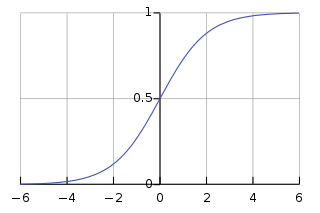
and is described analytically, 
$$ cases_{confirmed} \left( t \right) = \frac {S_\infty} {1 + e ^ {-k \left( t - t_m \right)}} $$ 

where $S_\infty$ is the number of people projected to become infected, $k$ is a growth factor (not equal, but relatable to the growth factor in the best-fit exponential curve), and $t_m$ is the median time of the regional epidemic.

While it might be possible to introduce a transform to the standard logistic function $$\frac {1} {1 + e ^ {-k \left( t - t_m \right)}} $$ of two variables $ k $ and $ t_m $ to render it amenable to linear regression, it will not be possible to use linear regression to fit a curve to this function that possesses three independent variables.  Furthermore, a quick survey of machine learning libraries did not reveal an algorithm that works with a numerator other than 1.  

Instead, I write a class to handle the type of regression that is needed.